STEP 5: LSTM Model Training and Evaluation
This step loads preprocessed sequences, builds an LSTM model to predict next-hour traffic density, trains and validates the model, and saves the trained model for future inference.

In [1]:
import numpy as np
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [2]:
# Load sequences
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# Load scaler (optional, for inverse transform later)
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (473, 48, 1)
y_train shape: (473,)
X_test shape: (119, 48, 1)
y_test shape: (119,)


In [3]:
model = Sequential([
    LSTM(96, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.15),

    LSTM(48),
    Dropout(0.15),

    Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)
model.summary()

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 48, 96)         │        37,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 48)             │        27,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,521 (255.94 KB)

 Trainable params: 65,521 (255.94 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-5
)


In [5]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.2354 - mae: 0.4073 - val_loss: 0.0806 - val_mae: 0.2344 - learning_rate: 0.0010
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0601 - mae: 0.1955 - val_loss: 0.0741 - val_mae: 0.2057 - learning_rate: 0.0010
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0454 - mae: 0.1623 - val_loss: 0.0693 - val_mae: 0.2048 - learning_rate: 0.0010
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0388 - mae: 0.1502 - val_loss: 0.0696 - val_mae: 0.2092 - learning_rate: 0.0010
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0433 - mae: 0.1616 - val_loss: 0.0686 - val_mae: 0.2044 - learning_rate: 0.0010
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0408 - mae: 0.1554 - val_loss: 0.0685 - val_mae: 0.2072 - learning_rate: 0.0010
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0375 - mae: 0.1485 - val_loss: 0.0680 - val_mae: 0.2037 - learning_rate: 0.0010
Epoch 

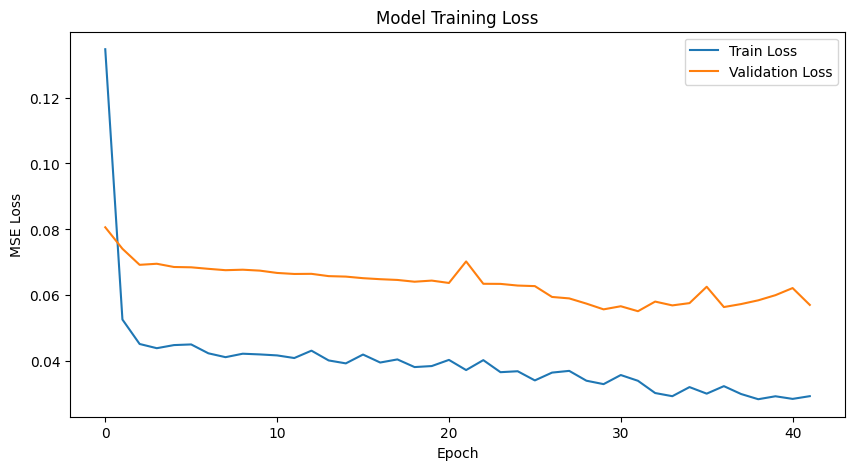

In [6]:
# Plot Training History
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


In [7]:
# Evaluate Model on Test Set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Test MSE: 0.0552
Test MAE: 0.1933


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


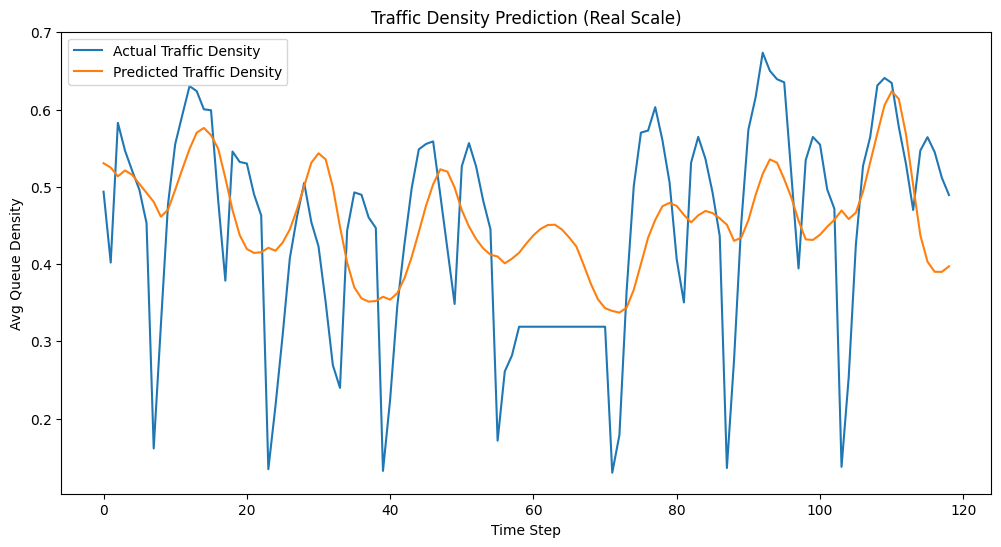

In [8]:
# Make Predictions and Inverse Transform
y_pred = model.predict(X_test)

# Inverse transform (REAL SCALE)
y_pred_real = scaler.inverse_transform(y_pred)
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))

# =========================
# Plot: Real-scale prediction
# =========================
plt.figure(figsize=(12,6))
plt.plot(y_test_real, label="Actual Traffic Density")
plt.plot(y_pred_real, label="Predicted Traffic Density")
plt.title("Traffic Density Prediction (Real Scale)")
plt.xlabel("Time Step")
plt.ylabel("Avg Queue Density")
plt.legend()
plt.show()

In [9]:
import os

os.makedirs("models", exist_ok=True)


In [10]:
model.save("models/lstm_traffic_model.keras")
print("Trained LSTM model saved successfully.")


Trained LSTM model saved successfully.


Outcome of STEP 5:
An LSTM model was trained to predict next-hour traffic density.
The model was evaluated on a test set and visualized predictions versus actual traffic.
The trained model was saved as lstm_traffic_model.h5 for future inference in the frontend application.